# 목차

### 0. Import
 - [Import Library](#Import-Library)
 - [Load Data](#Load-Data)
 - [Checking Column](#Checking-Column)

### 1. Train Data
- [1-1. Train Data_Preprocessing](#1-1.-Train-Data_Preprocessing)
- [1-2. Train Data_Feature Generation](#1-2.-Train-Data_Feature-Generation)
- [1-3. Train Data_Scalering](#1-3.-Train-Data_Scalering)

### 2. Test Data
- [2-1. Test Data_Preprocessing](#2-1.-Test-Data_Preprocessing)
- [2-2. Test Data_Feature_Generation](#2-2.-Test-Data_Feature_Generation)
- [2-3. Test Data_Scalering](#2-3.-Test-Data_Scalering)

### 3. Valid Data
- [3-1. Valid Data_Preprocessing](#3-1.-Valid-Data_Preprocessing)
- [3-2. Valid Data_Feature Generation](#3-2.-Valid-Data_Feature-Generation)
- [3-3. Valid Data_Scalering](#3-3.-Valid-Data_Scalering)

### 4. Feature Selection
- [Feataue Importance Visualization](#Feataue-Importance-Visualization)

### 5. Modeling
- [Data Split](#Data_Split)
- [DecisionTreeClassifier](#DecisionTreeClassifier)
- [RandomForestClassifier](#RandomForestClassifier)
- [ExtraTreeClassifier](#ExtraTreeClassifier)
- [LightBGM](#LightBGM)
- [AdaBoostClassifier](#AdaBoostClassifier)
- [KNN](#KNN)
- [모델 평균 성능 확인](#모델-평균-성능-확인)
- [HpyerParameter Tuning](#HpyerParameter-Tuning)

### 6. test파일 제작 및 성능 확인 
- [test파일 생성](#test파일-생성)
- [test파일 성능 확인](#test파일-성능-확인)

# 0.import

### Import Library

In [ ]:
# !pip install category_encoders
# !pip install catboost
# !pip install optuna
# !pip install eli5

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import re
import math
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, cross_validate, KFold
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import optuna
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV, ShapleyImportanceEvaluator
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷

### Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#colab version
train = pd.read_csv('/content/drive/MyDrive/프로젝트/게임플레이이력바탕_이상유저분류/train.csv') #학습에 사용되는 데이터
test = pd.read_csv('/content/drive/MyDrive/프로젝트/게임플레이이력바탕_이상유저분류/test.csv') #'is_bot'column에 TRUE, FALSE로 기입
val = pd.read_csv('/content/drive/MyDrive/프로젝트/게임플레이이력바탕_이상유저분류/valid.csv') #학습 중 평가에 사용되는 검증 데이터

In [ ]:
# #local version
# train = pd.read_csv('train.csv') #학습에 사용되는 데이터
# test = pd.read_csv('test.csv') #'is_bot'column에 TRUE, FALSE로 기입
# val = pd.read_csv('valid.csv') #학습 중 평가에 사용되는 검증 데이터

### Checking Column

In [ ]:
#feature확인
print(len(train.columns))
print(len(test.columns))
print(len(val.columns))

print(train.columns)
print(test.columns)
print(val.columns)

16
15
15
Index(['account_id', 'sequence', 'char_level', 'char_type', 'job_1',
       'social_status_1', 'social_status_2', 'social_status_3',
       'social_status_4', 'activity_cum_score_1', 'activity_cum_score_2',
       'activity_cum_score_3', 'activity_score_1', 'activity_score_2',
       'activity_score_3', 'is_bot'],
      dtype='object')
Index(['account_id', 'char_level', 'char_type', 'job_1', 'social_status_1',
       'social_status_2', 'social_status_3', 'social_status_4',
       'activity_cum_score_1', 'activity_cum_score_2', 'activity_cum_score_3',
       'activity_score_1', 'activity_score_2', 'activity_score_3', 'is_bot'],
      dtype='object')
Index(['account_id', 'char_level', 'char_type', 'job_1', 'social_status_1',
       'social_status_2', 'social_status_3', 'social_status_4',
       'activity_cum_score_1', 'activity_cum_score_2', 'activity_cum_score_3',
       'activity_score_1', 'activity_score_2', 'activity_score_3', 'is_bot'],
      dtype='object')


-> 'sequence' column은 train에만 존재, test, val에는 존재X

# 1-1. Train Data_Preprocessing

### Column Engineering

- train데이터에서 sequence칼럼을 제거했습니다

In [ ]:
train1 = train.drop(columns = ['sequence'],axis=1)
train1

,account_id,char_level,char_type,job_1,social_status_1,social_status_2,social_status_3,social_status_4,activity_cum_score_1,activity_cum_score_2,activity_cum_score_3,activity_score_1,activity_score_2,activity_score_3,is_bot
0,15,96,0,1,True,True,False,False,63986,175635,5648,17,85,83051,False
1,16,56,1,1,True,False,False,False,4,11460,51,0,600,21670,False
2,16,60,1,3,True,False,False,False,7,11460,51,0,600,21670,False
3,17,46,1,0,False,False,False,False,1,2220,2,1,120,1461,False
4,19,39,0,4,False,False,False,False,1,100,1,0,1250,26662,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135363,68836,2,0,2,False,False,False,False,1,40,1,0,80,1152,False
135364,68837,3,1,0,False,False,False,False,1,100,1,0,100,160,False
135365,68846,6,1,0,False,False,False,False,1,100,1,0,300,676,False
135366,68849,14,1,4,False,False,False,False,1,100,1,0,700,1686,False


### Outlier

- 이상치 처리 기준 : 1사분위값 - IQR*1.5미만 or 3사분위값 + IQR*1.5초과

In [ ]:
columns = ['char_level', 'activity_score_1', 'activity_score_3']
for col in columns:
    q1=train1[col].quantile(0.25)
    q3=train1[col].quantile(0.75)
    IQR=q3-q1
    # 소수점(1.5, 2.5) 형태로 나와서 올림 처리
    line_down = math.ceil(q1 - IQR * 1.5)
    line_up = math.ceil(q3 + IQR * 1.5) 
    
    train1[col] = train1[col].clip(line_down, line_up)

### OneHotEncoding

In [ ]:
train1 = train1.replace({True:1, False:0})

# 1-2. Train Data_Feature Generation

- 상관관계 확인

<AxesSubplot:>

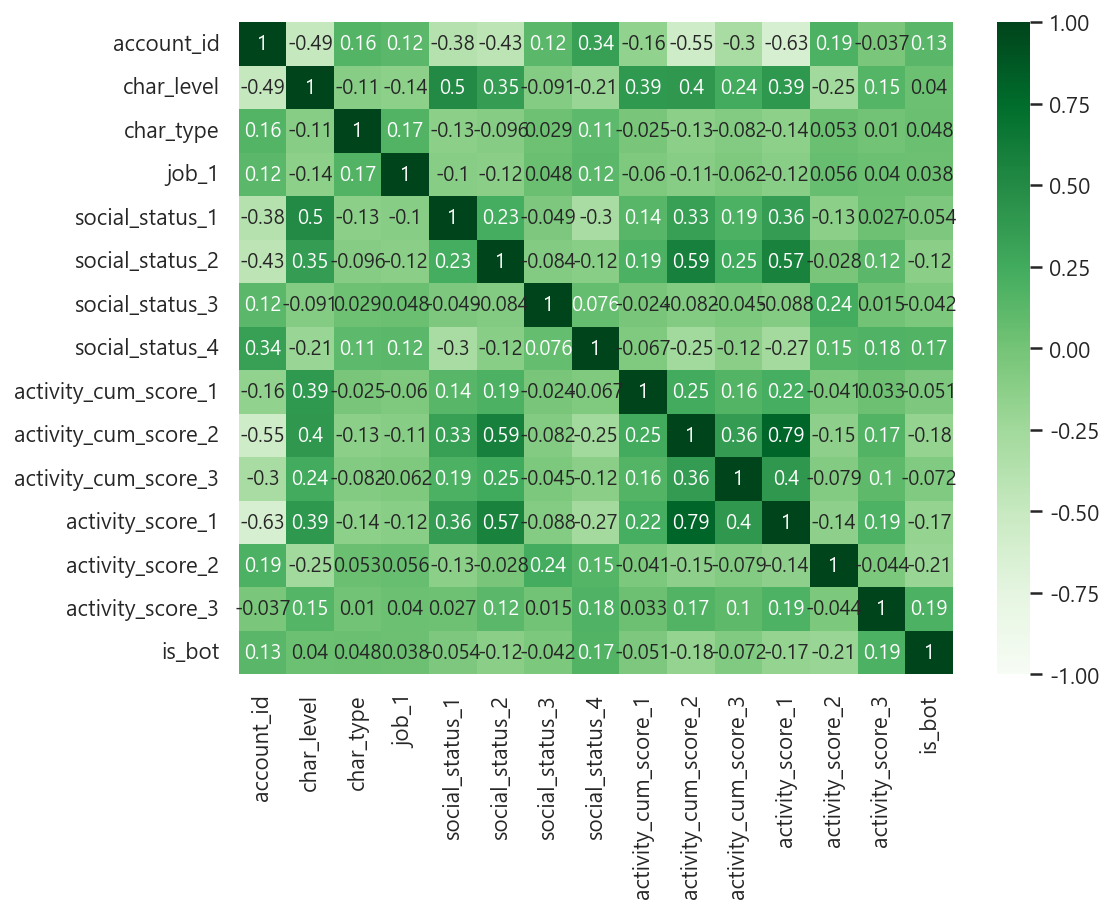

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
sns.heatmap(train1.corr(),annot=True, cmap='Greens',vmin=-1,vmax=1)

- account_id기준으로 확인

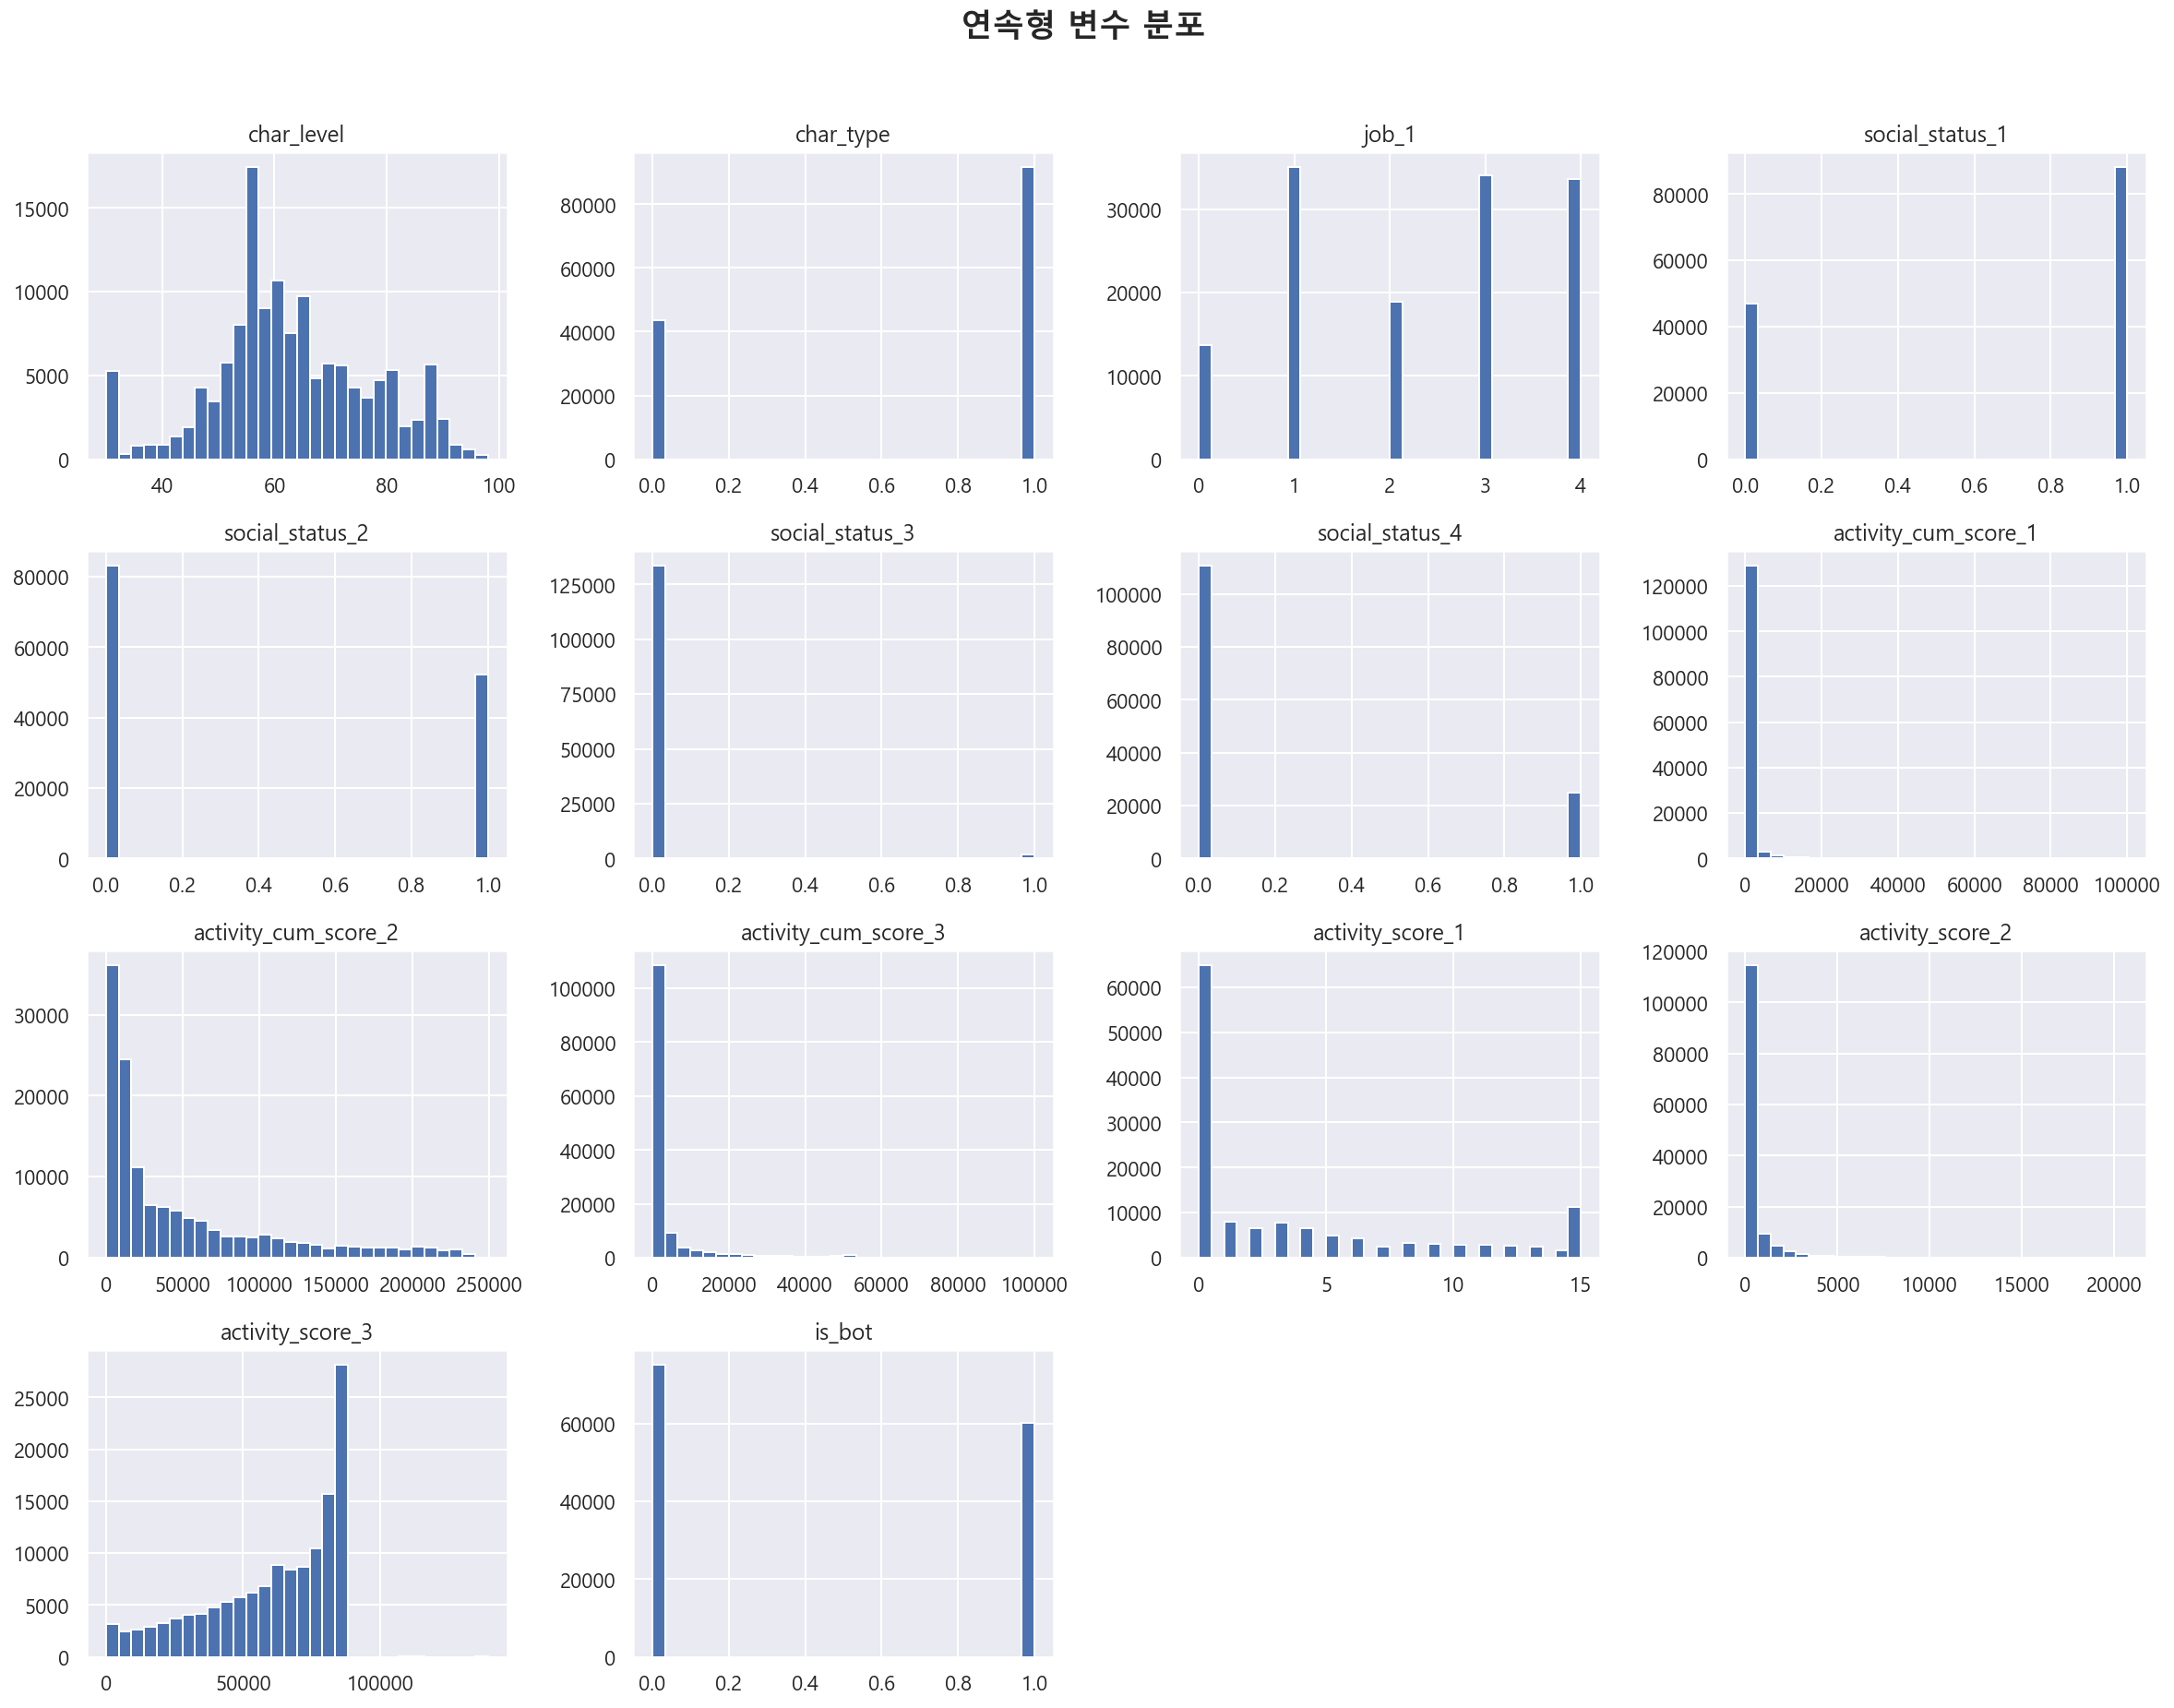

In [ ]:
g = train1.set_index('account_id').hist(bins=30,figsize=(20,15))
plt.suptitle("연속형 변수 분포", x=0.5, y=0.95, ha='center', fontsize='xx-large', fontweight=800)
plt.show()

In [ ]:
#총 활동점수
train1['total_cum_score'] = train1['activity_cum_score_1'] + train1['activity_cum_score_2'] + train1['activity_cum_score_3']
#직업별 캐릭터 레벨
train1['total_activity_score'] = train1['activity_score_1'] + train1['activity_score_2'] + train1['activity_score_3']
#직업별 총 누적 점수
train1['job_level'] = train1.groupby(['job_1'])['char_level'].transform('mean')
#직업별 총 활동 점수
train1['job_cum_sum'] = train1.groupby(['job_1'])['total_cum_score'].transform('mean')
#날짜별 캐릭터 레벨
train1['job_activity_sum'] = train1.groupby(['job_1'])['total_activity_score'].transform('mean')

- randomforest를 이용해서 val, test data에 sequence column 생성

In [ ]:
train['sequence'].unique()

array([0, 1, 2], dtype=int64)

# 1-3. Train Data_Scalering

Text(0.5, 1.0, 'Before Scalering')

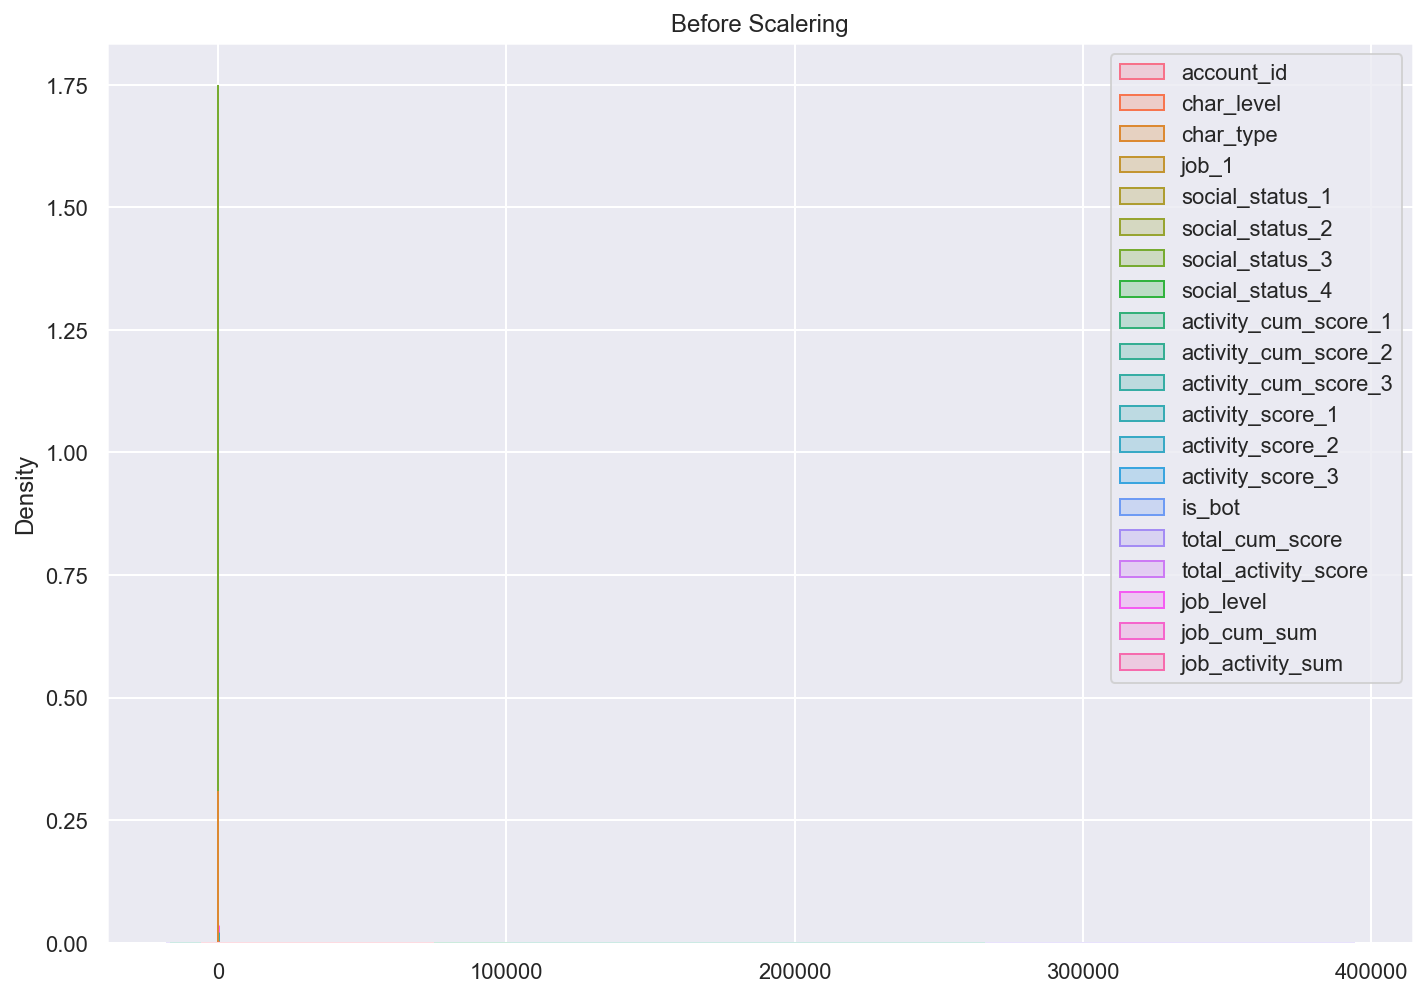

In [ ]:
#Before Scalering
numerical_feats = train1.dtypes[train1.dtypes == "int64"].index.tolist()
li = train1.dtypes[train1.dtypes == "float64"].index.tolist()
numerical_feats = numerical_feats + li
sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = train1[numerical_feats], shade = True).set_title('Before Scalering')

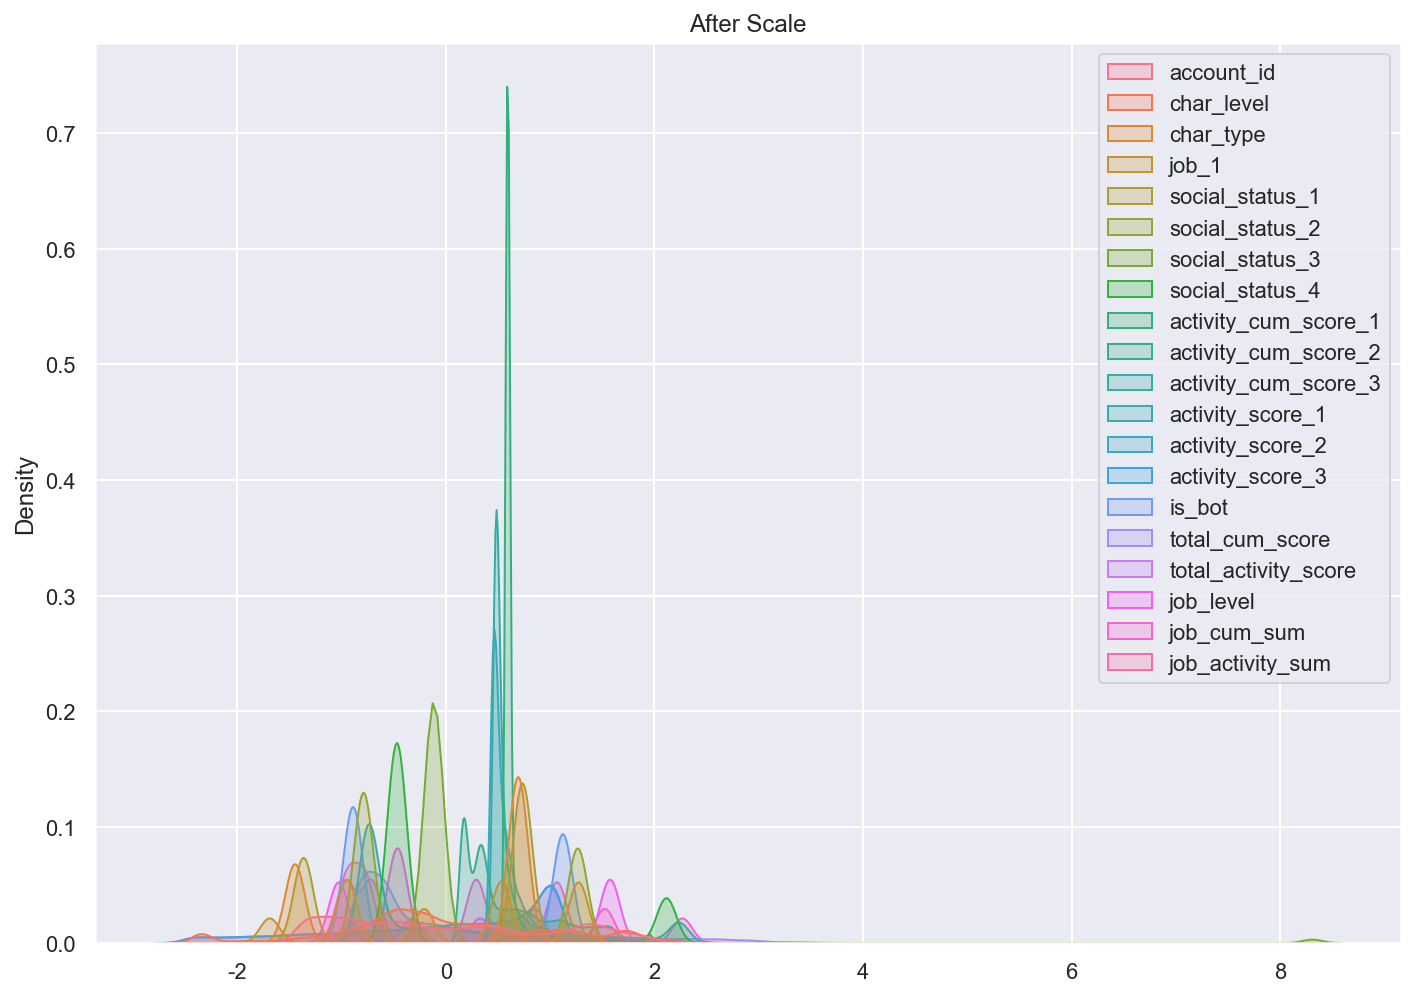

In [ ]:
#standard Scaler
scaler = StandardScaler()
train1[numerical_feats] = scaler.fit_transform(train1[numerical_feats])

train1['activity_cum_score_1'] = np.log1p(1+train1['activity_cum_score_1'])
train1['activity_cum_score_2'] = np.log1p(1+train1['activity_cum_score_2'])
train1['activity_cum_score_3'] = np.log1p(1+train1['activity_cum_score_3'])
train1['activity_score_2'] = np.log1p(1+train1['activity_score_2'])

#After Sclalering
sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = train1[numerical_feats], shade = True).set_title('After Scale')
plt.show()

# 2-1. Test Data_Preprocessing

### Outlier

- 이상치 처리 기준 : 1사분위값 - IQR*1.5미만 or 3사분위값 + IQR*1.5초과

In [ ]:
columns = ['char_level', 'activity_score_1', 'activity_score_3']
for col in columns:
    q1=test[col].quantile(0.25)
    q3=test[col].quantile(0.75)
    IQR=q3-q1
    # 소수점(1.5, 2.5) 형태로 나와서 올림 처리
    line_down = math.ceil(q1 - IQR * 1.5)
    line_up = math.ceil(q3 + IQR * 1.5) 
    
    test[col] = test[col].clip(line_down, line_up)

- 이상치 없는 feature : char_type, job_1
- 이상치가 매우 높은 feature : activity_cum_score_1,activity_cum_score_2, activity_cum_score_3,activity_score_2
=> 이상치 높은 feature는 scaling진행    

### OneHotEncoding

In [ ]:
test = test.replace({True:1, False:0})

# 2-2. Test Data_Feature Generation

In [ ]:
#총 활동점수
test['total_cum_score'] = test['activity_cum_score_1'] + test['activity_cum_score_2'] + test['activity_cum_score_3']
#직업별 캐릭터 레벨
test['total_activity_score'] = test['activity_score_1'] + test['activity_score_2'] + test['activity_score_3']
#직업별 총 누적 점수
test['job_level'] = test.groupby(['job_1'])['char_level'].transform('mean')
#직업별 총 활동 점수
test['job_cum_sum'] = test.groupby(['job_1'])['total_cum_score'].transform('mean')
#날짜별 캐릭터 레벨
test['job_activity_sum'] = test.groupby(['job_1'])['total_activity_score'].transform('mean')

# 2-3. Test Data_Scalering

Text(0.5, 1.0, 'Before Scalering')

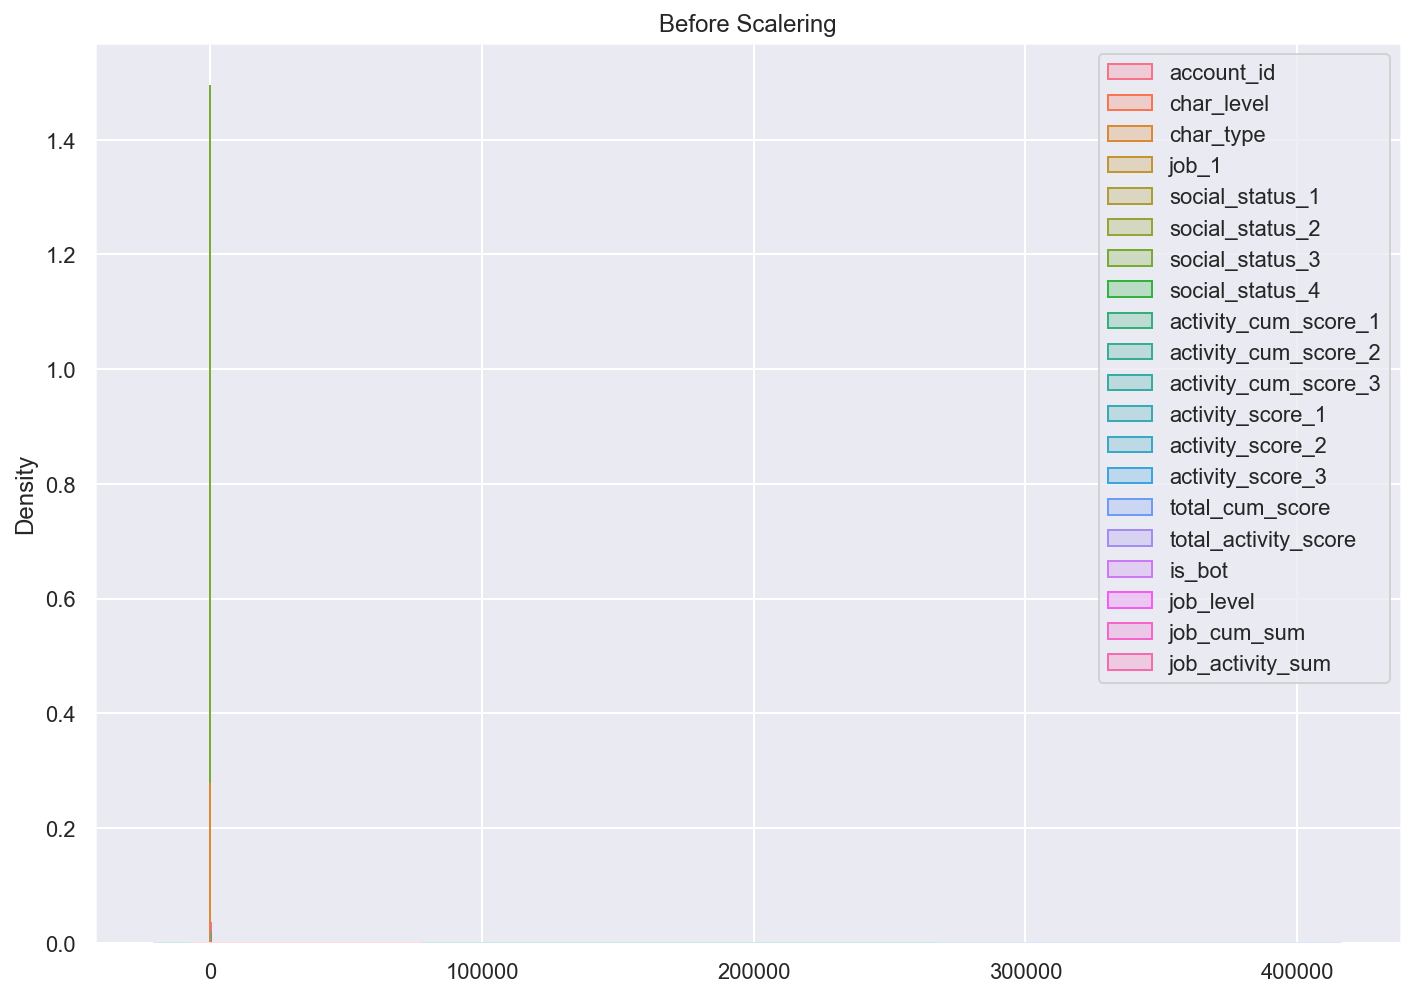

In [ ]:
#Before Scalering
numerical_feats = test.dtypes[test.dtypes == "int64"].index.tolist()
li = test.dtypes[test.dtypes == "float64"].index.tolist()
numerical_feats = numerical_feats + li
sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = test[numerical_feats], shade = True).set_title('Before Scalering')

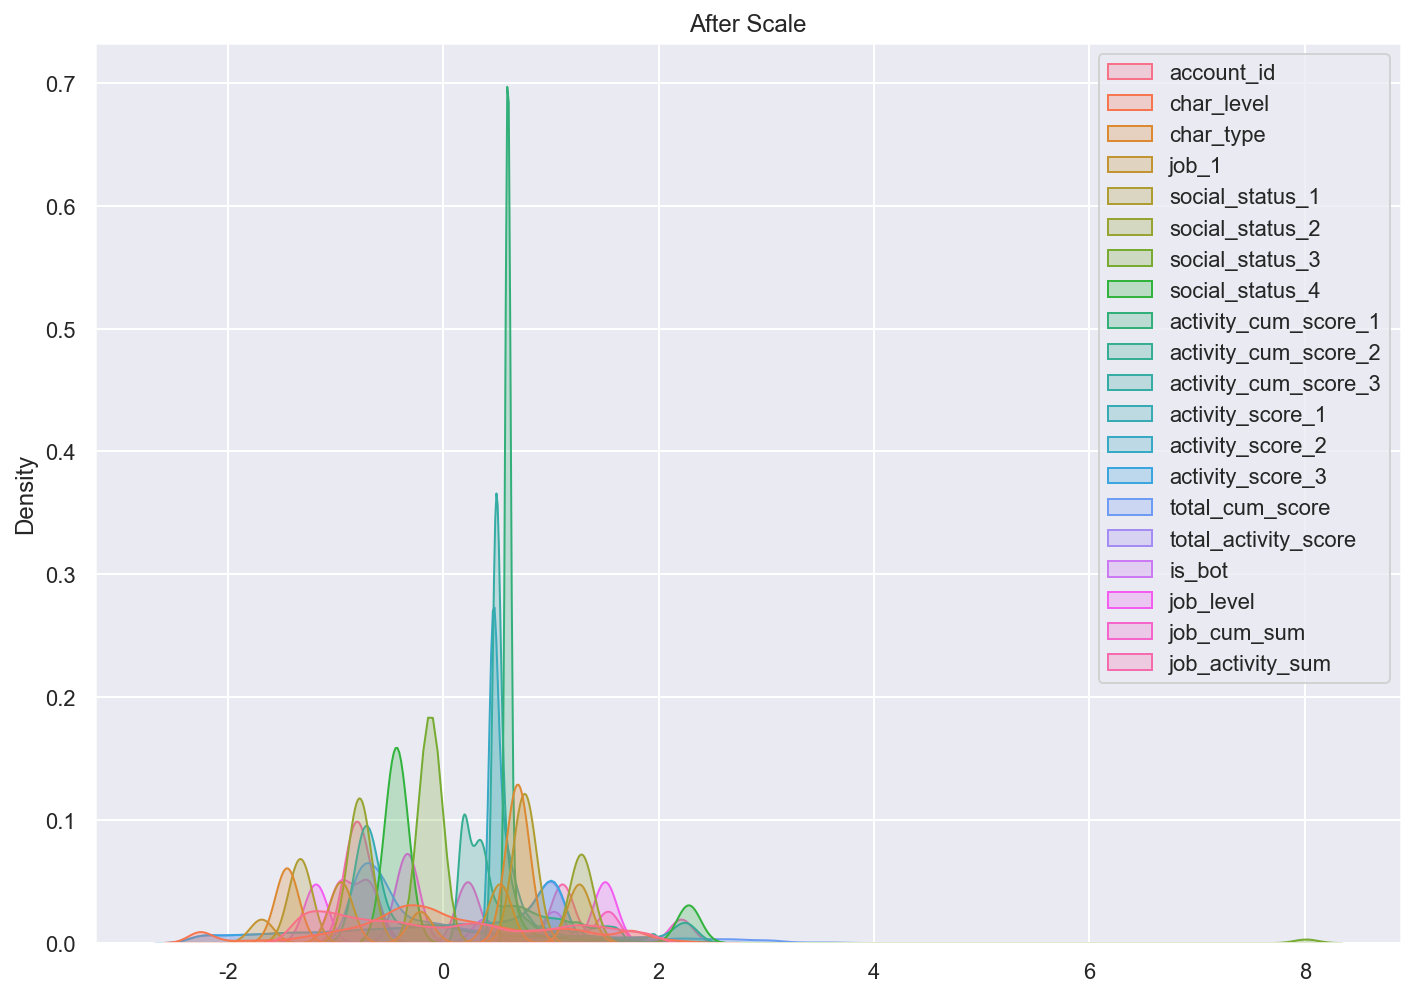

In [ ]:
#standard Scaler
scaler = StandardScaler()
test[numerical_feats] = scaler.fit_transform(test[numerical_feats])

test['activity_cum_score_1'] = np.log1p(1+test['activity_cum_score_1'])
test['activity_cum_score_2'] = np.log1p(1+test['activity_cum_score_2'])
test['activity_cum_score_3'] = np.log1p(1+test['activity_cum_score_3'])
test['activity_score_2'] = np.log1p(1+test['activity_score_2'])

#After Sclalering
sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = test[numerical_feats], shade = True).set_title('After Scale')
plt.show()

# 3-1. Valid Data_Preprocessing

### Outlier

- 이상치 처리 기준 : 1사분위값 - IQR1.5미만 or 3사분위값 + IQR1.5초과

In [ ]:
columns = ['char_level', 'activity_score_1', 'activity_score_3']
for col in columns:
    q1=val[col].quantile(0.25)
    q3=val[col].quantile(0.75)
    IQR=q3-q1
    # 소수점(1.5, 2.5) 형태로 나와서 올림 처리
    line_down = math.ceil(q1 - IQR * 1.5)
    line_up = math.ceil(q3 + IQR * 1.5) 
    
    val[col] = val[col].clip(line_down, line_up)

### OneHot Encoding

In [ ]:
val = val.replace({True:1, False:0})

# 3-2. Valid Data_Feature Generation

In [ ]:
#총 활동점수
val['total_cum_score'] = val['activity_cum_score_1'] + val['activity_cum_score_2'] + val['activity_cum_score_3']
#직업별 캐릭터 레벨
val['total_activity_score'] = val['activity_score_1'] + val['activity_score_2'] + val['activity_score_3']
#직업별 총 누적 점수
val['job_level'] = val.groupby(['job_1'])['char_level'].transform('mean')
#직업별 총 활동 점수
val['job_cum_sum'] = val.groupby(['job_1'])['total_cum_score'].transform('mean')
#날짜별 캐릭터 레벨
val['job_activity_sum'] = val.groupby(['job_1'])['total_activity_score'].transform('mean')

# 3-3. Valid Data_Scalering

Text(0.5, 1.0, 'Before Scalering')

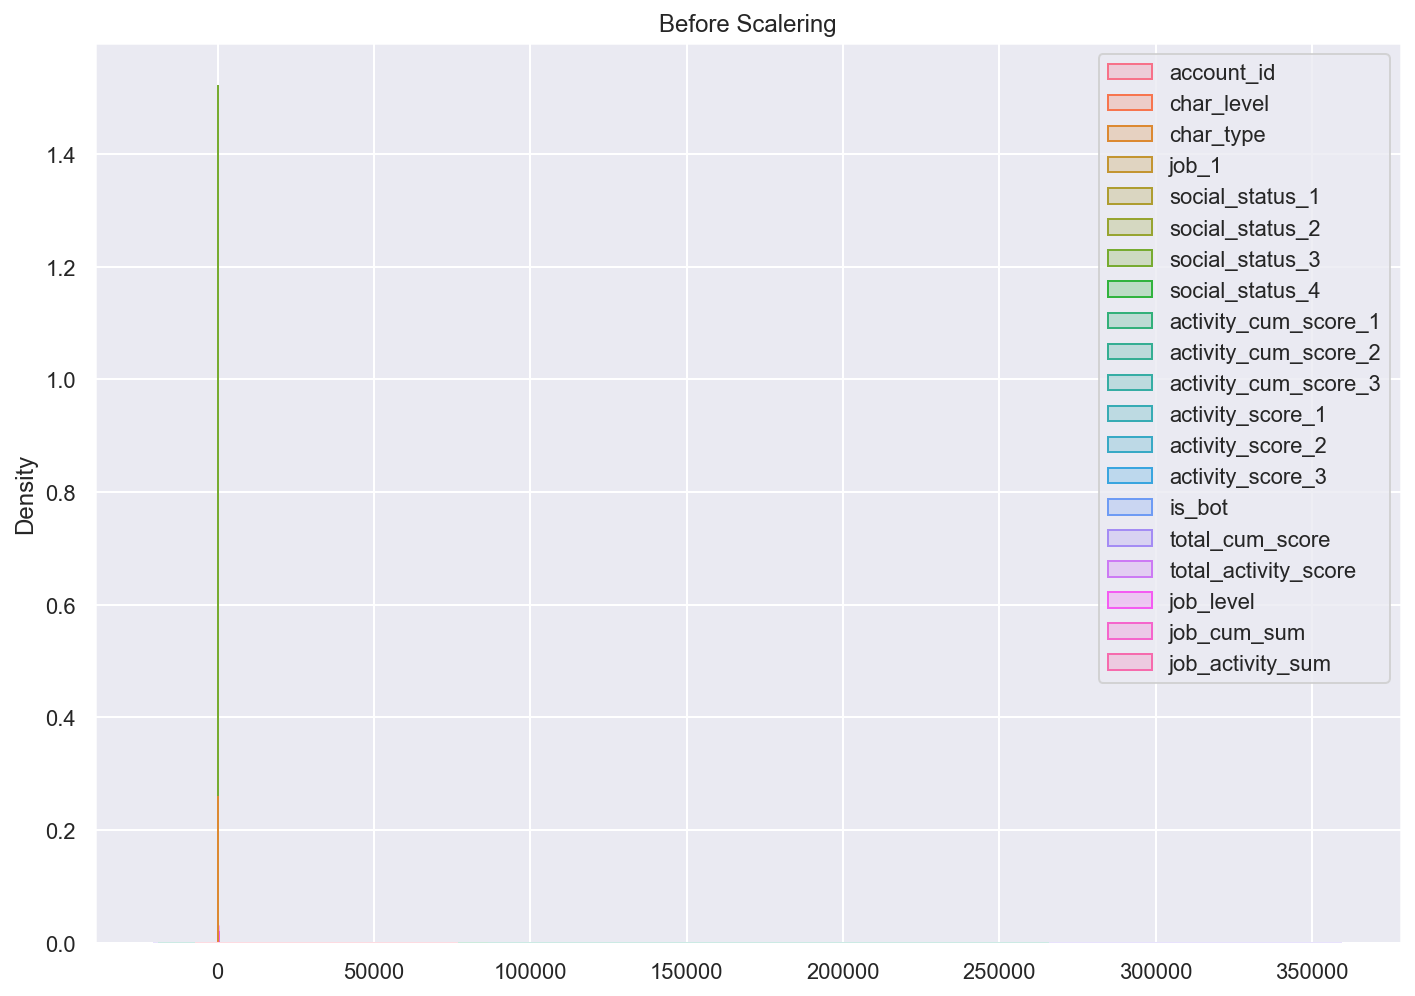

In [ ]:
#Before Scalering
numerical_feats = val.dtypes[val.dtypes == "int64"].index.tolist()
li = val.dtypes[val.dtypes == "float64"].index.tolist()
numerical_feats = numerical_feats + li
sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = val[numerical_feats], shade = True).set_title('Before Scalering')

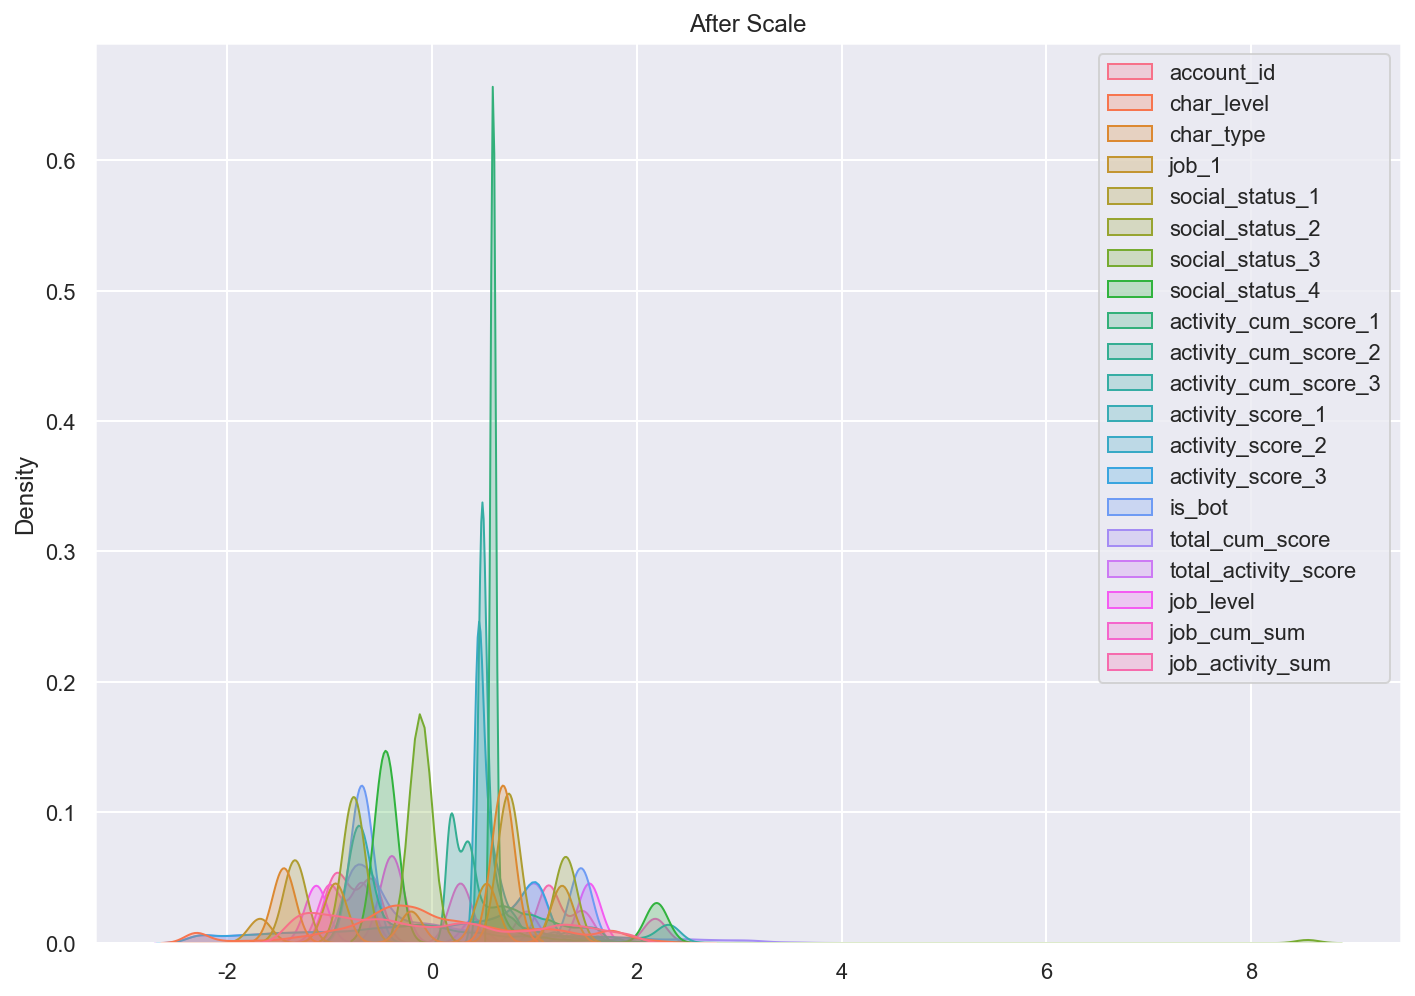

In [ ]:
#standard Scaler
scaler = StandardScaler()
val[numerical_feats] = scaler.fit_transform(val[numerical_feats])

val['activity_cum_score_1'] = np.log1p(1+val['activity_cum_score_1'])
val['activity_cum_score_2'] = np.log1p(1+val['activity_cum_score_2'])
val['activity_cum_score_3'] = np.log1p(1+val['activity_cum_score_3'])
val['activity_score_2'] = np.log1p(1+val['activity_score_2'])

#After Sclalering
sns.set(rc={'figure.figsize':(11.7,8.27)},)
sns.kdeplot(data = val[numerical_feats], shade = True).set_title('After Scale')
plt.show()

### Sequence칼럼 처리

- Randomforest를 이용해서 validation데이터, test데이터에 ‘sequence’ column 생성

1. val 데이터의 sequence column 생성

In [ ]:
#train데이터에서 target값으로 'sequence' column설정

X_train = train1
y_train = train['sequence']
X_train

,account_id,char_level,char_type,job_1,social_status_1,social_status_2,social_status_3,social_status_4,activity_cum_score_1,activity_cum_score_2,activity_cum_score_3,activity_score_1,activity_score_2,activity_score_3,is_bot,total_cum_score,total_activity_score,job_level,job_cum_sum,job_activity_sum
0,-1.445325,2.361085,-1.450856,-0.953270,0.730302,1.259786,-0.120423,-0.47388,3.055721,1.427968,0.793256,2.232901,0.484325,0.924128,-0.894902,3.032694,0.910164,1.569806,0.286484,-0.953817
1,-1.445274,-0.495154,0.689248,-0.953270,0.730302,-0.793785,-0.120423,-0.47388,0.587385,0.312178,0.471293,-0.742483,0.763526,-1.602242,-0.894902,-0.653121,-1.597987,1.569806,0.286484,-0.953817
2,-1.445274,-0.209530,0.689248,0.527056,0.730302,-0.793785,-0.120423,-0.47388,0.587892,0.312178,0.471293,-0.742483,0.763526,-1.602242,-0.894902,-0.653073,-1.597987,-0.457974,-0.718009,-0.776561
3,-1.445223,-1.209214,0.689248,-1.693433,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.189458,0.467962,-0.544124,0.505977,-2.434022,-0.894902,-0.799636,-2.450283,0.324491,2.262453,-0.324311
4,-1.445122,-1.709056,-1.450856,1.267219,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.159044,0.467894,-0.742483,1.031621,-1.396778,-0.894902,-0.833080,-1.365550,-1.032106,-0.966354,1.061306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135363,2.060749,-2.351709,-1.450856,-0.213107,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.158169,0.467894,-0.742483,0.481193,-2.446740,-0.894902,-0.834026,-2.464702,-0.486438,0.849702,1.518400
135364,2.060800,-2.351709,0.689248,-1.693433,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.159044,0.467894,-0.742483,0.493662,-2.487569,-0.894902,-0.833080,-2.504746,0.324491,2.262453,-0.324311
135365,2.061258,-2.351709,0.689248,-1.693433,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.159044,0.467894,-0.742483,0.610479,-2.466331,-0.894902,-0.833080,-2.475249,0.324491,2.262453,-0.324311
135366,2.061411,-2.351709,0.689248,1.267219,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.159044,0.467894,-0.742483,0.809744,-2.424761,-0.894902,-0.833080,-2.417160,-1.032106,-0.966354,1.061306


In [ ]:
#val데이터에 0으로 채워진 sequence 칼럼 추가

val['sequence'] = np.nan
val = val.fillna(0)
X_val = val.drop(columns=['sequence'])
y_val = val['sequence']
X_val

,account_id,char_level,char_type,job_1,social_status_1,social_status_2,social_status_3,social_status_4,activity_cum_score_1,activity_cum_score_2,activity_cum_score_3,activity_score_1,activity_score_2,activity_score_3,is_bot,total_cum_score,total_activity_score,job_level,job_cum_sum,job_activity_sum
0,-1.439992,-2.311883,0.689309,0.528488,-1.342962,1.301525,-0.117026,-0.456814,0.589737,0.253594,0.473728,-0.721192,0.992753,-2.253416,-0.689834,-0.727216,-2.229952,-0.372862,-0.685963,-0.586712
1,-1.407956,1.388120,0.689309,1.266048,0.744623,1.301525,-0.117026,-0.456814,0.629120,0.724941,0.509753,0.087280,0.488157,-2.162101,-0.689834,0.005544,-2.178007,-1.134457,-1.005012,1.133165
2,-1.386284,-0.077919,-1.450729,-0.209071,0.744623,1.301525,-0.117026,-0.456814,0.589737,1.648785,1.201604,1.502106,0.628747,-0.257300,-0.689834,3.153165,-0.261888,-0.442977,0.922451,1.466911
3,-1.386284,2.016422,-1.450729,0.528488,0.744623,1.301525,-0.117026,-0.456814,1.151470,1.648785,1.201604,1.502106,0.628747,-0.257300,-0.689834,3.221747,-0.261888,-0.372862,-0.685963,-0.586712
4,-1.386284,-1.055278,-1.450729,-0.946631,0.744623,1.301525,-0.117026,-0.456814,0.589737,1.648785,1.201604,1.502106,0.628747,-0.257300,-0.689834,3.153165,-0.261888,1.532452,0.274050,-0.958068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57064,1.843422,-0.776033,0.689309,-0.209071,0.744623,-0.768330,-0.117026,2.189074,0.589737,0.228602,0.475525,-0.721192,0.526780,-1.396310,1.449623,-0.756341,-1.409222,-0.442977,0.922451,1.466911
57065,1.853787,-0.776033,-1.450729,1.266048,-1.342962,-0.768330,-0.117026,2.189074,0.589737,0.174469,0.475884,-0.721192,0.599821,-0.595172,1.449623,-0.817763,-0.602518,-1.134457,-1.005012,1.133165
57066,1.935962,-1.334524,0.689309,1.266048,-1.342962,-0.768330,-0.117026,2.189074,0.589737,0.205535,0.474016,-0.721192,0.488157,-1.663527,-0.689834,-0.783305,-1.679087,-1.134457,-1.005012,1.133165
57067,1.964229,-1.055278,0.689309,-0.946631,-1.342962,-0.768330,-0.117026,2.189074,0.589737,0.177170,0.474879,-0.721192,1.765530,-0.173110,1.449623,-0.815005,-0.030971,1.532452,0.274050,-0.958068


In [ ]:
#sequence를 target 지정해서 모델 훈련시킨 후 validation data의 sequence예측

rmf = RandomForestClassifier(n_estimators=200, criterion='entropy',random_state=42)
rmf.fit(X_train,y_train)
rmf_pred = rmf.predict(X_val)
seq = pd.DataFrame(rmf_pred).rename(columns={0:'sequence'})

#위에서 예측한 seq값을 validation데이터의 sequence에 할당
X_val['sequence'] = seq
val = X_val
val

,account_id,char_level,char_type,job_1,social_status_1,social_status_2,social_status_3,social_status_4,activity_cum_score_1,activity_cum_score_2,...,activity_score_1,activity_score_2,activity_score_3,is_bot,total_cum_score,total_activity_score,job_level,job_cum_sum,job_activity_sum,sequence
0,-1.439992,-2.311883,0.689309,0.528488,-1.342962,1.301525,-0.117026,-0.456814,0.589737,0.253594,...,-0.721192,0.992753,-2.253416,-0.689834,-0.727216,-2.229952,-0.372862,-0.685963,-0.586712,2
1,-1.407956,1.388120,0.689309,1.266048,0.744623,1.301525,-0.117026,-0.456814,0.629120,0.724941,...,0.087280,0.488157,-2.162101,-0.689834,0.005544,-2.178007,-1.134457,-1.005012,1.133165,2
2,-1.386284,-0.077919,-1.450729,-0.209071,0.744623,1.301525,-0.117026,-0.456814,0.589737,1.648785,...,1.502106,0.628747,-0.257300,-0.689834,3.153165,-0.261888,-0.442977,0.922451,1.466911,2
3,-1.386284,2.016422,-1.450729,0.528488,0.744623,1.301525,-0.117026,-0.456814,1.151470,1.648785,...,1.502106,0.628747,-0.257300,-0.689834,3.221747,-0.261888,-0.372862,-0.685963,-0.586712,2
4,-1.386284,-1.055278,-1.450729,-0.946631,0.744623,1.301525,-0.117026,-0.456814,0.589737,1.648785,...,1.502106,0.628747,-0.257300,-0.689834,3.153165,-0.261888,1.532452,0.274050,-0.958068,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57064,1.843422,-0.776033,0.689309,-0.209071,0.744623,-0.768330,-0.117026,2.189074,0.589737,0.228602,...,-0.721192,0.526780,-1.396310,1.449623,-0.756341,-1.409222,-0.442977,0.922451,1.466911,2
57065,1.853787,-0.776033,-1.450729,1.266048,-1.342962,-0.768330,-0.117026,2.189074,0.589737,0.174469,...,-0.721192,0.599821,-0.595172,1.449623,-0.817763,-0.602518,-1.134457,-1.005012,1.133165,1
57066,1.935962,-1.334524,0.689309,1.266048,-1.342962,-0.768330,-0.117026,2.189074,0.589737,0.205535,...,-0.721192,0.488157,-1.663527,-0.689834,-0.783305,-1.679087,-1.134457,-1.005012,1.133165,2
57067,1.964229,-1.055278,0.689309,-0.946631,-1.342962,-0.768330,-0.117026,2.189074,0.589737,0.177170,...,-0.721192,1.765530,-0.173110,1.449623,-0.815005,-0.030971,1.532452,0.274050,-0.958068,2


2. test 데이터의 sequence column 생성

In [ ]:
#test데이터에 0으로 채워진 sequence 칼럼 추가

test['sequence'] = np.nan
test = test.fillna(0)
X_test = test.drop(columns=['sequence'])
y_test = test['sequence']
X_test

,account_id,char_level,char_type,job_1,social_status_1,social_status_2,social_status_3,social_status_4,activity_cum_score_1,activity_cum_score_2,activity_cum_score_3,activity_score_1,activity_score_2,activity_score_3,is_bot,total_cum_score,total_activity_score,job_level,job_cum_sum,job_activity_sum
0,-1.404971,1.176131,-1.455868,-0.953552,0.750720,1.278274,-0.124867,-0.439512,0.693748,0.195165,1.003543,-0.525081,0.781812,1.061008,0.0,-0.617058,1.070720,1.499331,0.223679,-0.786995
1,-1.403865,0.900773,0.686876,-1.691339,0.750720,1.278274,-0.124867,-0.439512,0.604169,1.366947,0.575230,2.245857,0.784013,0.907787,0.0,1.735669,0.917926,0.373664,2.206631,-0.626449
2,-1.403865,0.281218,0.686876,1.259809,0.750720,1.278274,-0.124867,-0.439512,0.594310,1.366947,0.575230,2.245857,0.784013,0.907787,0.0,1.734738,0.917926,-1.187124,-0.960314,1.101774
3,-1.403865,1.726847,-1.455868,-0.953552,0.750720,1.278274,-0.124867,-0.439512,0.898862,1.366947,0.575230,2.245857,0.784013,0.907787,0.0,1.768195,0.917926,1.499331,0.223679,-0.786995
4,-1.403865,0.281218,0.686876,-0.953552,0.750720,1.278274,-0.124867,-0.439512,0.594310,1.366947,0.575230,2.245857,0.784013,0.907787,0.0,1.734738,0.917926,1.499331,0.223679,-0.786995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60898,1.807958,-1.715128,0.686876,1.259809,-1.332055,-0.782305,-0.124867,-0.439512,0.592429,0.195308,0.477000,-0.723005,0.775182,-1.254409,0.0,-0.792370,-1.250191,-1.187124,-0.960314,1.101774
60899,1.866409,-1.095573,0.686876,1.259809,-1.332055,-0.782305,-0.124867,-0.439512,0.592429,0.203916,0.478411,-0.723005,0.560854,-1.281656,0.0,-0.782320,-1.294634,-1.187124,-0.960314,1.101774
60900,1.888491,-0.682536,0.686876,0.522022,0.750720,-0.782305,-0.124867,-0.439512,0.592600,0.246613,0.485370,-0.723005,0.762687,0.756374,0.0,-0.731203,0.763714,-0.326684,-0.700316,-0.845760
60901,1.922070,-0.957894,0.686876,1.259809,-1.332055,-0.782305,-0.124867,-0.439512,0.592429,0.209496,0.478008,-0.723005,0.605453,-0.181902,0.0,-0.776075,-0.189300,-1.187124,-0.960314,1.101774


In [ ]:
#sequence를 target 지정해서 모델 훈련시킨 후 test data의 sequence예측
rmf_pred = rmf.predict(X_test)
seq = pd.DataFrame(rmf_pred).rename(columns={0:'sequence'})

#위에서 예측한 seq값을 validation데이터의 sequence에 할당
X_test['sequence'] = seq
test = X_test
test

,account_id,char_level,char_type,job_1,social_status_1,social_status_2,social_status_3,social_status_4,activity_cum_score_1,activity_cum_score_2,...,activity_score_1,activity_score_2,activity_score_3,is_bot,total_cum_score,total_activity_score,job_level,job_cum_sum,job_activity_sum,sequence
0,-1.404971,1.176131,-1.455868,-0.953552,0.750720,1.278274,-0.124867,-0.439512,0.693748,0.195165,...,-0.525081,0.781812,1.061008,0.0,-0.617058,1.070720,1.499331,0.223679,-0.786995,2
1,-1.403865,0.900773,0.686876,-1.691339,0.750720,1.278274,-0.124867,-0.439512,0.604169,1.366947,...,2.245857,0.784013,0.907787,0.0,1.735669,0.917926,0.373664,2.206631,-0.626449,1
2,-1.403865,0.281218,0.686876,1.259809,0.750720,1.278274,-0.124867,-0.439512,0.594310,1.366947,...,2.245857,0.784013,0.907787,0.0,1.734738,0.917926,-1.187124,-0.960314,1.101774,1
3,-1.403865,1.726847,-1.455868,-0.953552,0.750720,1.278274,-0.124867,-0.439512,0.898862,1.366947,...,2.245857,0.784013,0.907787,0.0,1.768195,0.917926,1.499331,0.223679,-0.786995,1
4,-1.403865,0.281218,0.686876,-0.953552,0.750720,1.278274,-0.124867,-0.439512,0.594310,1.366947,...,2.245857,0.784013,0.907787,0.0,1.734738,0.917926,1.499331,0.223679,-0.786995,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60898,1.807958,-1.715128,0.686876,1.259809,-1.332055,-0.782305,-0.124867,-0.439512,0.592429,0.195308,...,-0.723005,0.775182,-1.254409,0.0,-0.792370,-1.250191,-1.187124,-0.960314,1.101774,2
60899,1.866409,-1.095573,0.686876,1.259809,-1.332055,-0.782305,-0.124867,-0.439512,0.592429,0.203916,...,-0.723005,0.560854,-1.281656,0.0,-0.782320,-1.294634,-1.187124,-0.960314,1.101774,2
60900,1.888491,-0.682536,0.686876,0.522022,0.750720,-0.782305,-0.124867,-0.439512,0.592600,0.246613,...,-0.723005,0.762687,0.756374,0.0,-0.731203,0.763714,-0.326684,-0.700316,-0.845760,2
60901,1.922070,-0.957894,0.686876,1.259809,-1.332055,-0.782305,-0.124867,-0.439512,0.592429,0.209496,...,-0.723005,0.605453,-0.181902,0.0,-0.776075,-0.189300,-1.187124,-0.960314,1.101774,2


3. X_train에 다시 sequence추가

In [ ]:
sequence = pd.read_csv('train.csv')['sequence']
train = pd.concat([X_train,sequence],axis=1)
train

,account_id,char_level,char_type,job_1,social_status_1,social_status_2,social_status_3,social_status_4,activity_cum_score_1,activity_cum_score_2,...,activity_score_1,activity_score_2,activity_score_3,is_bot,total_cum_score,total_activity_score,job_level,job_cum_sum,job_activity_sum,sequence
0,-1.445325,2.361085,-1.450856,-0.953270,0.730302,1.259786,-0.120423,-0.47388,3.055721,1.427968,...,2.232901,0.484325,0.924128,-0.894902,3.032694,0.910164,1.569806,0.286484,-0.953817,0
1,-1.445274,-0.495154,0.689248,-0.953270,0.730302,-0.793785,-0.120423,-0.47388,0.587385,0.312178,...,-0.742483,0.763526,-1.602242,-0.894902,-0.653121,-1.597987,1.569806,0.286484,-0.953817,0
2,-1.445274,-0.209530,0.689248,0.527056,0.730302,-0.793785,-0.120423,-0.47388,0.587892,0.312178,...,-0.742483,0.763526,-1.602242,-0.894902,-0.653073,-1.597987,-0.457974,-0.718009,-0.776561,0
3,-1.445223,-1.209214,0.689248,-1.693433,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.189458,...,-0.544124,0.505977,-2.434022,-0.894902,-0.799636,-2.450283,0.324491,2.262453,-0.324311,0
4,-1.445122,-1.709056,-1.450856,1.267219,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.159044,...,-0.742483,1.031621,-1.396778,-0.894902,-0.833080,-1.365550,-1.032106,-0.966354,1.061306,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135363,2.060749,-2.351709,-1.450856,-0.213107,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.158169,...,-0.742483,0.481193,-2.446740,-0.894902,-0.834026,-2.464702,-0.486438,0.849702,1.518400,2
135364,2.060800,-2.351709,0.689248,-1.693433,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.159044,...,-0.742483,0.493662,-2.487569,-0.894902,-0.833080,-2.504746,0.324491,2.262453,-0.324311,2
135365,2.061258,-2.351709,0.689248,-1.693433,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.159044,...,-0.742483,0.610479,-2.466331,-0.894902,-0.833080,-2.475249,0.324491,2.262453,-0.324311,2
135366,2.061411,-2.351709,0.689248,1.267219,-1.369296,-0.793785,-0.120423,-0.47388,0.586879,0.159044,...,-0.742483,0.809744,-2.424761,-0.894902,-0.833080,-2.417160,-1.032106,-0.966354,1.061306,2


In [ ]:
#column수가 맞춰짐
print(len(train.columns))
print(len(test.columns))
print(len(val.columns))

21
21
21


# 4. Feature Selection

### Feataue Importance Visualization

In [ ]:
#train, test, val데이터 X로 concat
X = pd.concat([train,test,val],ignore_index=True).drop(columns='is_bot')
X

,account_id,char_level,char_type,job_1,social_status_1,social_status_2,social_status_3,social_status_4,activity_cum_score_1,activity_cum_score_2,activity_cum_score_3,activity_score_1,activity_score_2,activity_score_3,total_cum_score,total_activity_score,job_level,job_cum_sum,job_activity_sum,sequence
0,-1.445325,2.361085,-1.450856,-0.953270,0.730302,1.259786,-0.120423,-0.473880,3.055721,1.427968,0.793256,2.232901,0.484325,0.924128,3.032694,0.910164,1.569806,0.286484,-0.953817,0
1,-1.445274,-0.495154,0.689248,-0.953270,0.730302,-0.793785,-0.120423,-0.473880,0.587385,0.312178,0.471293,-0.742483,0.763526,-1.602242,-0.653121,-1.597987,1.569806,0.286484,-0.953817,0
2,-1.445274,-0.209530,0.689248,0.527056,0.730302,-0.793785,-0.120423,-0.473880,0.587892,0.312178,0.471293,-0.742483,0.763526,-1.602242,-0.653073,-1.597987,-0.457974,-0.718009,-0.776561,0
3,-1.445223,-1.209214,0.689248,-1.693433,-1.369296,-0.793785,-0.120423,-0.473880,0.586879,0.189458,0.467962,-0.544124,0.505977,-2.434022,-0.799636,-2.450283,0.324491,2.262453,-0.324311,0
4,-1.445122,-1.709056,-1.450856,1.267219,-1.369296,-0.793785,-0.120423,-0.473880,0.586879,0.159044,0.467894,-0.742483,1.031621,-1.396778,-0.833080,-1.365550,-1.032106,-0.966354,1.061306,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253335,1.843422,-0.776033,0.689309,-0.209071,0.744623,-0.768330,-0.117026,2.189074,0.589737,0.228602,0.475525,-0.721192,0.526780,-1.396310,-0.756341,-1.409222,-0.442977,0.922451,1.466911,2
253336,1.853787,-0.776033,-1.450729,1.266048,-1.342962,-0.768330,-0.117026,2.189074,0.589737,0.174469,0.475884,-0.721192,0.599821,-0.595172,-0.817763,-0.602518,-1.134457,-1.005012,1.133165,1
253337,1.935962,-1.334524,0.689309,1.266048,-1.342962,-0.768330,-0.117026,2.189074,0.589737,0.205535,0.474016,-0.721192,0.488157,-1.663527,-0.783305,-1.679087,-1.134457,-1.005012,1.133165,2
253338,1.964229,-1.055278,0.689309,-0.946631,-1.342962,-0.768330,-0.117026,2.189074,0.589737,0.177170,0.474879,-0.721192,1.765530,-0.173110,-0.815005,-0.030971,1.532452,0.274050,-0.958068,2


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

imp = rmf.feature_importances_
imp_df = pd.DataFrame(imp, index=X_train.columns, columns=["imp"])
imp_df = imp_df.sort_values("imp", ascending=False)
imp_df

,imp
activity_cum_score_2,0.122298
account_id,0.114834
activity_score_3,0.113263
total_activity_score,0.111246
activity_cum_score_3,0.106151
total_cum_score,0.104191
activity_score_2,0.098671
char_level,0.052897
activity_cum_score_1,0.041985
activity_score_1,0.039976


# 5. Modeling

### Data Split

In [ ]:
train = X[:len(train)]
test = X[len(train):len(train)+len(test)]
val = X[len(train)+len(test):]

In [ ]:
X_train = train
X_test = test
X_val = val
#colab
y_train = pd.read_csv('/content/drive/MyDrive/프로젝트/게임플레이이력바탕_이상유저분류/train.csv')['is_bot']
y_test = pd.read_csv('/content/drive/MyDrive/프로젝트/게임플레이이력바탕_이상유저분류/test.csv')['is_bot']
y_val = pd.read_csv('/content/drive/MyDrive/프로젝트/게임플레이이력바탕_이상유저분류/valid.csv')['is_bot']
# #local
# y_train = pd.read_csv('train.csv')['is_bot']
# y_test = pd.read_csv('test.csv')['is_bot']
# y_val = pd.read_csv('valid.csv')['is_bot']

In [ ]:
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(135368, 20) (60903, 20) (57069, 20)
(135368,) (60903,) (57069,)


### DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(random_state=20)
dt.fit(X_train,y_train)
dt_pred = dt.predict(X_val)

In [ ]:
print('accuracy : ', accuracy_score(y_val,dt_pred))
print('f1 : ', f1_score(y_val,dt_pred))

accuracy :  0.6603760360265644
f1 :  0.55787216570099


### RandomForestClassifier

In [ ]:
rmf = RandomForestClassifier(n_estimators=200, criterion='entropy',random_state=42)
rmf.fit(X_train,y_train)
rmf_pred = rmf.predict(X_val)

In [ ]:
print('accuracy : ', accuracy_score(y_val,rmf_pred))
print('f1 : ', f1_score(y_val,rmf_pred))

accuracy :  0.7734496837162032
f1 :  0.6800623592586177


### ExtraTreeClassifier

In [ ]:
ex = ExtraTreesClassifier(random_state = 42)
ex.fit(X_train, y_train)
ex_pred = ex.predict(X_val)

In [ ]:
print('accuracy : ', accuracy_score(y_val,ex_pred))
print('f1 : ', f1_score(y_val,ex_pred))

accuracy :  0.8126303246946679
f1 :  0.7207146028678143


### LightBGM

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
lgbm_pred = lgbm.predict(X_val)

In [ ]:
print('accuracy : ', accuracy_score(y_val,lgbm_pred))
print('f1 : ', f1_score(y_val,lgbm_pred))

accuracy :  0.6967004853773502
f1 :  0.5635983158107052


### AdaBoostClassifier

In [ ]:
ada = AdaBoostClassifier(n_estimators=100) #아다부스트
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_val)

In [ ]:
print('accuracy : ', accuracy_score(y_val,ada_pred))
print('f1 : ', f1_score(y_val,ada_pred))

accuracy :  0.6741137920762585
f1 :  0.5355144855144855


### KNN

In [ ]:
knn  = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_val)

In [ ]:
print('accuracy : ', accuracy_score(y_val,knn_pred))
print('f1 : ', f1_score(y_val,knn_pred))

accuracy :  0.7650212900173474
f1 :  0.6331856228458888


### 모델 평균 성능 확인

- 여러개의 모델을 사용해서 accuracy_score와 f1_score를 비교하고 가장 높은 score가 나온 모델 선정

- 모델 목록
- DecisionTreeClassification, RandomforestClassifier, ExtraTreeClassifier, LightBGM, AdaBoostClassifier

In [ ]:
train_X = X_train
train_y = y_train

In [ ]:
# accuracy_score 함수
def ACCURACY(y_val, y_pred_val):
    accuracy = accuracy_score(y_val, y_pred_val) 
    return accuracy

# Cross Validation 함수
def accuracy_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    accuracy_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred_val = clf.predict(X_val)
        accuracy = ACCURACY(y_val, pred_val) 
        accuracy_list.append(accuracy)
    return model_name, accuracy_list

#cv별 프린팅, 평균 저장
def print_accuracy_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = accuracy_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} accuracy: {r:.4f}')
    print(f'\n{model_name} mean ACCURACY: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
#모델 정의
dt = DecisionTreeClassifier(random_state=20)
rmf = RandomForestClassifier(n_estimators=200, criterion='entropy',random_state=42)
ex = ExtraTreesClassifier(random_state = 42)
lgbm = LGBMClassifier()
ada = AdaBoostClassifier(n_estimators=100)
knn  = KNeighborsClassifier(n_neighbors=4)

models = []
scores = []
for model in [dt, rmf, ex, lgbm,ada, knn]:
    model_name, mean_score = print_accuracy_score(model)
    models.append(model_name)
    scores.append(mean_score)

DecisionTreeClassifier Cross Validations...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


1 FOLDS: DecisionTreeClassifier accuracy: 0.6373
2 FOLDS: DecisionTreeClassifier accuracy: 0.6081
3 FOLDS: DecisionTreeClassifier accuracy: 0.6247
4 FOLDS: DecisionTreeClassifier accuracy: 0.6016
5 FOLDS: DecisionTreeClassifier accuracy: 0.6294
6 FOLDS: DecisionTreeClassifier accuracy: 0.6344
7 FOLDS: DecisionTreeClassifier accuracy: 0.6373
8 FOLDS: DecisionTreeClassifier accuracy: 0.6469
9 FOLDS: DecisionTreeClassifier accuracy: 0.6579
10 FOLDS: DecisionTreeClassifier accuracy: 0.6316

DecisionTreeClassifier mean ACCURACY: 0.6309


RandomForestClassifier Cross Validations...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:35<00:00, 27.57s/it]


1 FOLDS: RandomForestClassifier accuracy: 0.7405
2 FOLDS: RandomForestClassifier accuracy: 0.7143
3 FOLDS: RandomForestClassifier accuracy: 0.7231
4 FOLDS: RandomForestClassifier accuracy: 0.7380
5 FOLDS: RandomForestClassifier accuracy: 0.7368
6 FOLDS: RandomForestClassifier accuracy: 0.7434
7 FOLDS: RandomForestClassifier accuracy: 0.7601
8 FOLDS: RandomForestClassifier accuracy: 0.7713
9 FOLDS: RandomForestClassifier accuracy: 0.7663
10 FOLDS: RandomForestClassifier accuracy: 0.7707

RandomForestClassifier mean ACCURACY: 0.7464


ExtraTreesClassifier Cross Validations...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.63s/it]


1 FOLDS: ExtraTreesClassifier accuracy: 0.7268
2 FOLDS: ExtraTreesClassifier accuracy: 0.7206
3 FOLDS: ExtraTreesClassifier accuracy: 0.7421
4 FOLDS: ExtraTreesClassifier accuracy: 0.7693
5 FOLDS: ExtraTreesClassifier accuracy: 0.7617
6 FOLDS: ExtraTreesClassifier accuracy: 0.7702
7 FOLDS: ExtraTreesClassifier accuracy: 0.7971
8 FOLDS: ExtraTreesClassifier accuracy: 0.8103
9 FOLDS: ExtraTreesClassifier accuracy: 0.8043
10 FOLDS: ExtraTreesClassifier accuracy: 0.8060

ExtraTreesClassifier mean ACCURACY: 0.7709


LGBMClassifier Cross Validations...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.45it/s]


1 FOLDS: LGBMClassifier accuracy: 0.6972
2 FOLDS: LGBMClassifier accuracy: 0.6674
3 FOLDS: LGBMClassifier accuracy: 0.6788
4 FOLDS: LGBMClassifier accuracy: 0.6924
5 FOLDS: LGBMClassifier accuracy: 0.7016
6 FOLDS: LGBMClassifier accuracy: 0.6849
7 FOLDS: LGBMClassifier accuracy: 0.7132
8 FOLDS: LGBMClassifier accuracy: 0.7117
9 FOLDS: LGBMClassifier accuracy: 0.7160
10 FOLDS: LGBMClassifier accuracy: 0.7031

LGBMClassifier mean ACCURACY: 0.6966


AdaBoostClassifier Cross Validations...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.76s/it]


1 FOLDS: AdaBoostClassifier accuracy: 0.6940
2 FOLDS: AdaBoostClassifier accuracy: 0.6355
3 FOLDS: AdaBoostClassifier accuracy: 0.6009
4 FOLDS: AdaBoostClassifier accuracy: 0.6183
5 FOLDS: AdaBoostClassifier accuracy: 0.6194
6 FOLDS: AdaBoostClassifier accuracy: 0.6284
7 FOLDS: AdaBoostClassifier accuracy: 0.6768
8 FOLDS: AdaBoostClassifier accuracy: 0.6674
9 FOLDS: AdaBoostClassifier accuracy: 0.6739
10 FOLDS: AdaBoostClassifier accuracy: 0.6771

AdaBoostClassifier mean ACCURACY: 0.6492


KNeighborsClassifier Cross Validations...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [10:47<00:00, 64.72s/it]

1 FOLDS: KNeighborsClassifier accuracy: 0.6468
2 FOLDS: KNeighborsClassifier accuracy: 0.6614
3 FOLDS: KNeighborsClassifier accuracy: 0.6979
4 FOLDS: KNeighborsClassifier accuracy: 0.7094
5 FOLDS: KNeighborsClassifier accuracy: 0.7083
6 FOLDS: KNeighborsClassifier accuracy: 0.7216
7 FOLDS: KNeighborsClassifier accuracy: 0.7481
8 FOLDS: KNeighborsClassifier accuracy: 0.7530
9 FOLDS: KNeighborsClassifier accuracy: 0.7531
10 FOLDS: KNeighborsClassifier accuracy: 0.7544

KNeighborsClassifier mean ACCURACY: 0.7154


In [ ]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,DecisionTreeClassifier,0.630919
1,RandomForestClassifier,0.746449
2,ExtraTreesClassifier,0.770860
3,LGBMClassifier,0.696639
4,AdaBoostClassifier,0.649177
5,KNeighborsClassifier,0.715395


=> 가장 좋은 성능을 나타내는 ExtraTreeclassifier을 최종 모델로 선정

### HpyerParameter Tuning

- 가장 좋은 성능을 나타내는 모델인 ExtraTreetClassifier로 파라미터 튜닝 진행

- ExtraTreetClassifier로 Optuna 실행

In [ ]:
# def objective(trial):

#     ### define params grid to search maximum accuracy
#     n_estimators = trial.suggest_int('n_estimators', 50, 300)
#     max_depth = trial.suggest_int('max_depth', 10, 30)
#     max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 15, 30)
#     criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

#     ### modeling with suggested params
#     model = ExtraTreesClassifier(n_estimators = n_estimators,
#                                  max_depth = max_depth,
#                                  max_leaf_nodes = max_leaf_nodes,
#                                  criterion = criterion,
#                                  random_state = 0) # do not tune the seed

#     ### fit
#     model.fit(X_train, y_train)
#     preds = model.predict(X_val)
#     y_pred_val = model.predict(X_val)
#     score = accuracy_score(y_val,y_pred_val)
#     score_mean = score.mean()
    
#     return score_mean
    
# study = optuna.create_study(direction='maximize') # maximize accuracy
# study.optimize(objective, n_trials=30)

In [ ]:
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)
# print('Best score:', study.best_value)

In [ ]:
# #params = {'n_estimators': 120, 'max_depth': 16, 'max_leaf_nodes': 25, 'criterion': 'gini'}
# params = {'n_estimators': 250, 'class_weight':'balanced','max_features':'sqrt','min_samples_split':8,'random_state':42}

# ex = ExtraTreesClassifier(**params)
# ex.fit(X_train, y_train)
# ex_pred = ex.predict(X_val)
# print('accuracy : ', accuracy_score(y_val,ex_pred))
# print('f1 : ', f1_score(y_val,ex_pred))

# 6. test파일 제작 및 성능 확인

### test파일 생성

- 성능이 가장 좋은 RandomForestClassifier로 최종 test파일 제작

In [ ]:
#test 파일생성
ex = ExtraTreesClassifier(random_state = 42)
ex.fit(X_train, y_train)
pred = ex.predict(X_test)
pred = pd.DataFrame(pred)
test = pd.concat([test.reset_index(drop=True),pred.reset_index(drop=True)],axis=1)
test = test.rename(columns={0:'is_bot'})
test.to_csv('./test_made_03161257.csv',index=False)
test

,account_id,char_level,char_type,job_1,social_status_1,social_status_2,social_status_3,social_status_4,activity_cum_score_1,activity_cum_score_2,...,activity_score_1,activity_score_2,activity_score_3,total_cum_score,total_activity_score,job_level,job_cum_sum,job_activity_sum,sequence,is_bot
0,-1.404971,1.176131,-1.455868,-0.953552,0.750720,1.278274,-0.124867,-0.439512,0.693748,0.195165,...,-0.525081,0.781812,1.061008,-0.617058,1.070720,1.499331,0.223679,-0.786995,2,False
1,-1.403865,0.900773,0.686876,-1.691339,0.750720,1.278274,-0.124867,-0.439512,0.604169,1.366947,...,2.245857,0.784013,0.907787,1.735669,0.917926,0.373664,2.206631,-0.626449,1,False
2,-1.403865,0.281218,0.686876,1.259809,0.750720,1.278274,-0.124867,-0.439512,0.594310,1.366947,...,2.245857,0.784013,0.907787,1.734738,0.917926,-1.187124,-0.960314,1.101774,1,False
3,-1.403865,1.726847,-1.455868,-0.953552,0.750720,1.278274,-0.124867,-0.439512,0.898862,1.366947,...,2.245857,0.784013,0.907787,1.768195,0.917926,1.499331,0.223679,-0.786995,1,False
4,-1.403865,0.281218,0.686876,-0.953552,0.750720,1.278274,-0.124867,-0.439512,0.594310,1.366947,...,2.245857,0.784013,0.907787,1.734738,0.917926,1.499331,0.223679,-0.786995,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60898,1.807958,-1.715128,0.686876,1.259809,-1.332055,-0.782305,-0.124867,-0.439512,0.592429,0.195308,...,-0.723005,0.775182,-1.254409,-0.792370,-1.250191,-1.187124,-0.960314,1.101774,2,False
60899,1.866409,-1.095573,0.686876,1.259809,-1.332055,-0.782305,-0.124867,-0.439512,0.592429,0.203916,...,-0.723005,0.560854,-1.281656,-0.782320,-1.294634,-1.187124,-0.960314,1.101774,2,False
60900,1.888491,-0.682536,0.686876,0.522022,0.750720,-0.782305,-0.124867,-0.439512,0.592600,0.246613,...,-0.723005,0.762687,0.756374,-0.731203,0.763714,-0.326684,-0.700316,-0.845760,2,True
60901,1.922070,-0.957894,0.686876,1.259809,-1.332055,-0.782305,-0.124867,-0.439512,0.592429,0.209496,...,-0.723005,0.605453,-0.181902,-0.776075,-0.189300,-1.187124,-0.960314,1.101774,2,False


### test파일 성능 확인

In [ ]:
#colab
X_test = pd.read_csv('/content/drive/MyDrive/프로젝트/게임플레이이력바탕_이상유저분류/test_made_03161257.csv').drop(columns='is_bot')
y_test = pd.read_csv('/content/drive/MyDrive/프로젝트/게임플레이이력바탕_이상유저분류/test_made_03161257.csv')['is_bot']
# #local
# X_test = pd.read_csv('test_made_03161257.csv').drop(columns='is_bot')
# y_test = pd.read_csv('test_made_03161257.csv')['is_bot']
ex = ExtraTreesClassifier(n_estimators=200, criterion='entropy',random_state=42)
ex.fit(X_train,y_train)
ex_pred = ex.predict(X_test)
print('accuracy : ', accuracy_score(y_test,ex_pred))
print('f1 : ', f1_score(y_test,ex_pred))

accuracy :  0.956488186132046
f1 :  0.928736621309095


=> 최종 성능 accuracy :  0.956488186132046
f1 :  0.928736621309095